In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory

In [4]:
# path for kaggle train/test
train_dir = '/kaggle/input/skin-lesion-dataset-le-wagon-1271/processed_data/Train_set'
test_dir = '/kaggle/input/skin-lesion-dataset-le-wagon-1271/processed_data/Test_set'
val_dir = '/kaggle/input/skin-lesion-dataset-le-wagon-1271/processed_data/Val_set'

train_data = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    seed=123,
    image_size=(400, 400),
    batch_size=32)
val_data = image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    seed=123,
    image_size=(400, 400),
    batch_size=32)
test_data = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(400, 400),
    batch_size=32)

Found 3586 files belonging to 2 classes.
Found 1260 files belonging to 2 classes.
Found 1800 files belonging to 2 classes.


In [5]:
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [6]:
def load_model():
    model = ResNet50(weights='imagenet', include_top=False, input_shape=(400,400,3))
    return model

def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False

    return model

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''

    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(200, activation='relu')
    prediction_layer = layers.Dense(2, activation='sigmoid')

    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])

    return model

def build_model():
       
    model = load_model()
    model = add_last_layers(model)
    
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy', 'Recall',f1_metric])
    return model

In [7]:
resnet_model = build_model()
resnet_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 13, 13, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 346112)            0         
                                                                 
 dense (Dense)               (None, 200)               69222600  
                                                                 
 dense_1 (Dense)             (None, 2)                 402       
                                                                 
Total params: 92,810,714
Trainable params: 69,223,002
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 10, 
                   verbose = 1, 
                   restore_best_weights = True)

In [9]:
history_1 = resnet_model.fit(train_data, 
                        epochs=50,
                        callbacks=[es],
                        validation_data=val_data,
                        batch_size=32,
                        verbose=1)

Epoch 1/50
113/113 [==============================] - 44s 285ms/step - loss: 0.6437 - accuracy: 0.8196 - recall: 0.8115 - f1_metric: 0.8086 - val_loss: 0.5027 - val_accuracy: 0.7968 - val_recall: 0.7857 - val_f1_metric: 0.7948
Epoch 2/50
113/113 [==============================] - 29s 256ms/step - loss: 0.1546 - accuracy: 0.9384 - recall: 0.9389 - f1_metric: 0.9344 - val_loss: 0.5721 - val_accuracy: 0.8040 - val_recall: 0.7802 - val_f1_metric: 0.7936
Epoch 3/50
113/113 [==============================] - 29s 256ms/step - loss: 0.0451 - accuracy: 0.9894 - recall: 0.9897 - f1_metric: 0.9896 - val_loss: 0.4746 - val_accuracy: 0.8341 - val_recall: 0.8016 - val_f1_metric: 0.8230
Epoch 4/50
113/113 [==============================] - 29s 258ms/step - loss: 0.0157 - accuracy: 0.9989 - recall: 0.9992 - f1_metric: 0.9989 - val_loss: 0.4678 - val_accuracy: 0.8500 - val_recall: 0.8246 - val_f1_metric: 0.8442
Epoch 5/50
113/113 [==============================] - 29s 253ms/step - loss: 0.0072 - accura

In [10]:
resnet_model.evaluate(test_data)

57/57 [==============================] - 11s 181ms/step - loss: 0.2554 - accuracy: 0.9233 - recall: 0.9161 - f1_metric: 0.9198


[0.25542962551116943,
 0.9233333468437195,
 0.9161111116409302,
 0.9197907447814941]

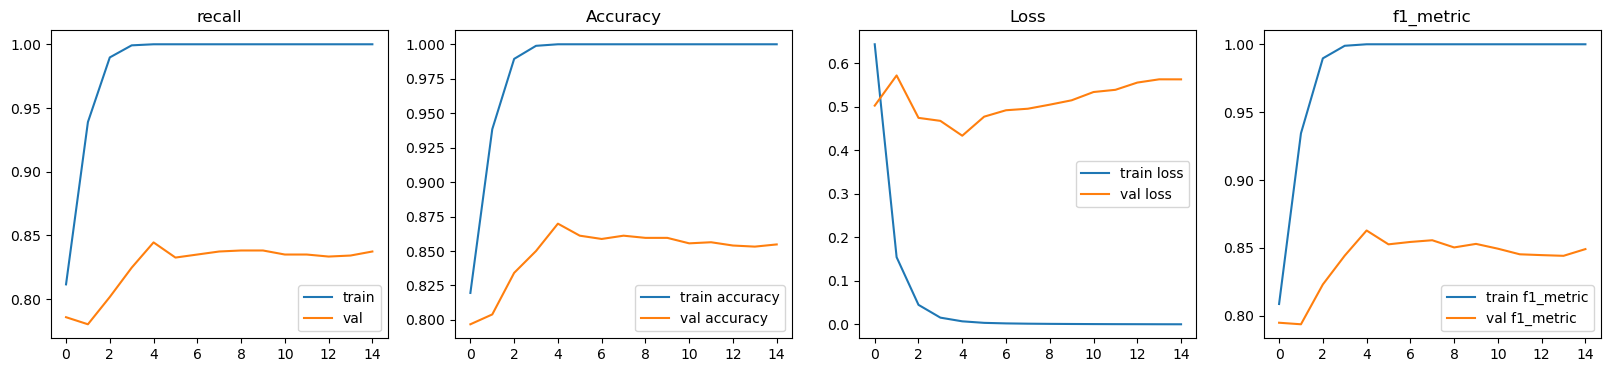

In [27]:
def plot_history(history, title='', axs=None, exp_name=""):
    f,(ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20, 4))
    
    ax1.plot(history.history['recall'], label='train')
    ax1.plot(history.history['val_recall'], label='val')
    #ax1.set_xlim(0., 5)
    ax1.set_title('recall')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy')
    ax2.plot(history.history['val_accuracy'], label='val accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()
    
    ax3.plot(history.history['loss'], label='train loss')
    ax3.plot(history.history['val_loss'], label='val loss')
    ax3.set_title('Loss')
    ax3.legend()
    
    ax4.plot(history.history['f1_metric'], label='train f1_metric')
    ax4.plot(history.history['val_f1_metric'], label='val f1_metric')
    ax4.set_title('f1_metric')
    ax4.legend()
    
    return (ax1, ax2, ax3, ax4)

plot_history(history_1);

In [12]:
import pickle
filename = 'resnet_model_4.pkl'
pickle.dump(resnet_model, open(filename, 'wb'))